### 1+2+3. Get and visualize the Data MNIST from Sklearn DataSets

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print("shape of X: ", X.shape)
print("shape of y: ", y.shape)

shape of X:  (70000, 784)
shape of y:  (70000,)


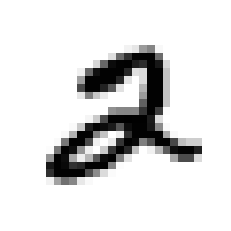

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[5]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [4]:
#cast y to integer
import numpy as np
y  = y.astype(np.uint8)

In [5]:
#Split the train set and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 4.1 Binary Classifier

### 4.1.1 Train a Stochastic Gradient Descent classifier using Scikit Learn

In [6]:
# such as for detect the number 2
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(random_state=42)

In [8]:
#predict the number in an image
sgd_clf.predict([some_digit])


array([ True])

### 4.1.2 Measuring Accuracy Using Cross-Validation

In [9]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) #number of folds is 3, 2 for train, 1 for validation

for train_index, test_index in skfolds.split(X_train, y_train_2):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_2[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_2[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.96645
0.95895
0.904


In [10]:
from sklearn.base import BaseEstimator

class Never2Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
from sklearn.model_selection import cross_val_score
never_2_clf = Never2Classifier()
cross_val_score(never_2_clf, X_train, y_train_2, cv=3, scoring='accuracy')


array([0.90355, 0.8993 , 0.89925])

### 4.1.3 Confusion Matrix

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)


In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_2, y_train_pred)

array([[51538,  2504],
       [  908,  5050]], dtype=int64)

### 4.1.4 Precision and Recall


In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_2, y_train_pred))
print(recall_score(y_train_2, y_train_pred))

0.6685199894095843
0.8475998657267539


In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_2, y_train_pred)

0.7474837181764358

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3, method='decision_function')

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)


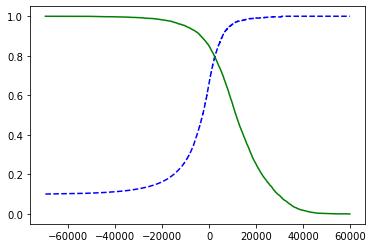

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
    [...]
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [19]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.9)]
threshold_90_precision

5585.140261597365

In [20]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [21]:
precision_score(y_train_2, y_train_pred_90)

0.9000641985876311

In [22]:
recall_score(y_train_2, y_train_pred_90)

0.7059415911379657

### 4.1.5 ROC curve

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

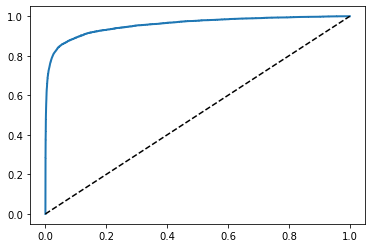

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    [...]

plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2, y_scores)

0.9568395257681235

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3, method='predict_proba')


In [29]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2,y_scores_forest)

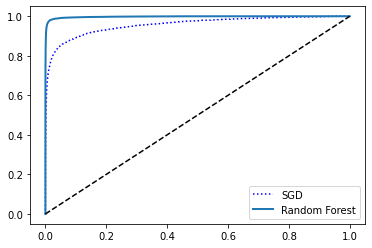

In [30]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_2, y_scores_forest)

0.9976087190102003